In [1]:
# Add module to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Imports
from aoc23.utils import read_input
import math
from itertools import product
from heapq import heapify, heappop, heappush
import matplotlib.pyplot as plt
import numpy as np

In [3]:
input_17 = read_input(17)

## Part 1

In part 1 of the [day 17 puzzle](https://adventofcode.com/2023/day/17), we are given an array containing digits representing the heat loss through each city block (I will call these tiles). A [crucible](https://en.wikipedia.org/wiki/Crucible) enters the grid at the top left corner, and makes its way to the bottom right corner of the grid, losing heat as it travels; the total heat loss is equal to the sum of the values of the tiles it passes through. The crucible has some restrictions on its movement:
1. It can only travel up to three blocks in a direction without turning 90° left or right
2. It cannot reverse direction - at each tile, it may only go left, right or straight (subject to rule 1).

The question is: what is the path that minimises the heat loss that the crucible incurs?

The solution I settled on for this problem used the A* algorithm (details on the [Wikipedia page](https://en.wikipedia.org/wiki/A*_search_algorithm)), by considering the grid of tiles as a weighted graph; each edge represents a possible path for the crucible to follow between turns. I wrapped my implementation up into a class called `PathFinder`, which is displayed here in its entirety. To summarise the main steps of the algorithm (in the context of this specific problem):
- The graph nodes are `(row, col, parity)` combinations. The `row` and `col` entries indicate the position in the grid, and the `parity` entry indicates if the crucible is moving in a N-S direction (`parity=0`) or a W-E direction (`parity=1`).
- The A* algorithm creates and maintains two quantities, usually referred to as $f$ and $g$, which are used to keep track of the values of each node in the weighted graph. Each of these is initialised at the start of the algorithm to $\infty$ for all of the graph nodes.
- The quantity $g$ is defined at each graph node $n$, and indicates the cost of the best path from the start to $n$ currently known.
- The quantity $f$ is defined at each graph node $n$, and indicates the current best guess of the value of the best path going through $n$. It is defined by:
$$
f(n) = g(n) + h(n),
$$
where $h(n)$ is a heuristic function estimating the cost of the best path from $n$ to the end. In order to guarantee that the solution found by A* is optimal, the function $h(n)$ must always be less than the true cost of the best path from $n$ to the end. In this case, the best we can do is:
$$
h(n) = |c - n_{col}| + |r - n_{row}|
$$
where $(c, r)$ are the total number of columns and rows in the full grid. This bound is satisfied if there are a sequence of $1$s connecting the node in a valid path directly to the end, and assumes that the minimum digit found anywhere in the grid is $1$.
- A collection of nodes is maintained, along with the corresponding $f$-score currently computed. At each step of the algorithm, the node with the minimal current $f$-score is removed from the collection, and used to make updates to the $f$ and $g$ scores. In order to find the node with the best $f$-score most efficiently, this collection of nodes is implemented as a binary heap, using the `heapq` built-in data type available in Python.
- At each step, once a node is obtained from the heap, all other valid connected nodes (i.e. those which can be reached by the crucible after turning) are identified. For each of these neighbouring nodes, a tentative $g$-score is computed by adding the $g$-score from the original node to the cost incurred from the step just performed. If the tentative $g$-score is better than the currently recorded one, the $f$ and $g$ scores are updated, and the new node is pushed onto the heap. The connection between the original node and the new node can also be recorded at this stage, to allow the optimal path to be more easily identified once the algorithm is complete.
- The algorithm continues until the node taken from the heap is the final node, at which point the $g$-score at this node can be read to give the optimal path cost. 

In [4]:
class PathFinder:
    
    def __init__(self, grid: list[str], min_step: int = 1, max_step: int = 3):
        self.grid = grid
        self.min_step = min_step
        self.max_step = max_step
        
        self.n_rows = len(grid)
        self.n_cols = len(grid[0])
        
        # Initialise f-scores and g-scores to infinity
        # Also initialise for the starting node
        self.g_score = {(row, col, parity): math.inf 
                        for row, col, parity in product(range(self.n_rows), range(self.n_cols), [0, 1])}
        self.g_score[(0, 0, 0)] = 0
        self.g_score[(0, 0, 1)] = 0
        
        self.f_score = {(row, col, parity): math.inf 
                        for row, col, parity in product(range(self.n_rows), range(self.n_cols), [0, 1])}
        self.f_score[(0, 0, 0)] = self.n_rows + self.n_cols - 2
        self.f_score[(0, 0, 1)] = self.n_rows + self.n_cols - 2
        
        # Create node heap
        self.nodes = []
        heapify(self.nodes)
        
        # Help to track the optimal paths
        self.came_from = {}
        self.optimal_came_from = {}
        self.optimal_path_found = False
        
        
    def compute_path(self):
        # Add the start node to the heap
        # One for each possible starting parity
        # Store as (f(n), n), so that natural ordering is
        # used by heap to order by f-score
        heappush(self.nodes, (self.f_score[(0, 0, 0)], (0, 0, 0)))
        heappush(self.nodes, (self.f_score[(0, 0, 1)], (0, 0, 1)))
        
        while len(self.nodes) > 0:
            # Pop the node with the best fscore
            _, (row, col, parity) = heappop(self.nodes)

            if row == self.n_rows-1 and col == self.n_cols-1:
                # Reached final node - terminate
                self.optimal_path_found = True
                return None
            
            # Defines the range of steps the crucible can take (see part 2)
            step_range = [*range(-self.max_step, -self.min_step+1), 
                          *range(self.min_step, self.max_step+1)]
            
            for i in step_range:
                # Check if this is a valid neighbouring node
                if parity % 2 == 0:
                    if not 0 <= row + i < self.n_rows:
                        continue
                    if i < 0:
                        d = sum([int(self.grid[row+k][col]) for k in range(i, 0)])    
                    else:
                        d = sum([int(self.grid[row+k][col]) for k in range(1, i+1)])
                        
                    neighbour = (row+i, col, (parity + 1) % 2)
                else:
                    if not 0 <= col + i < self.n_cols:
                        continue
                    if i < 0:
                        d = sum([int(self.grid[row][col+k]) for k in range(i, 0)])
                    else:
                        d = sum([int(self.grid[row][col+k]) for k in range(1, i+1)])
                        
                    neighbour = (row, col+i, (parity + 1) % 2)
                
                # Compute tentative g-score, and compare to current g-score
                tent_gscore = self.g_score[(row, col, parity)] + d
                if tent_gscore < self.g_score[neighbour]:
                    # Update came_from, g_score and f_score using heuristic h
                    self.came_from[neighbour] = (row, col)
                    self.g_score[neighbour] = tent_gscore
                    self.f_score[neighbour] = tent_gscore + \
                                              (self.n_rows - 1) - neighbour[0] + \
                                              (self.n_cols - 1) - neighbour[1]
                    # Push new node to heap
                    if neighbour not in self.nodes:
                        heappush(self.nodes, (self.f_score[neighbour], neighbour))
        
        # If heap is emptied before reaching final node, there is no valid path 
        raise ValueError('A* algorithm failed!')
        
        
    def find_best(self):
        assert self.optimal_path_found, 'Find optimal path first!'

        # There are 2 ways to reach the final tile (with each of the possible parities)
        # Find the one with the minimal g-score
        final_tiles = [self.g_score[(self.n_rows - 1, self.n_cols - 1, 0)],
                       self.g_score[(self.n_rows - 1, self.n_cols - 1, 1)]]
        print(f'Best final total: {min(final_tiles)}')

        self.optimal_came_from = {}

        if final_tiles[0] < final_tiles[1]:
            parity = 0
        else:
            parity = 1
    
        # Construct the optimal path, without the irrelevant parity
        node = (self.n_rows - 1, self.n_cols - 1)
        while node != (0, 0):
            prev_node_parity = self.came_from[(node[0], node[1], parity)]
            self.optimal_came_from[node] = (prev_node_parity[0], prev_node_parity[1])
            node = self.optimal_came_from[node]
            parity = (parity + 1) % 2

        return self.optimal_came_from

    
    def plot_path(self, **fig_kwargs):
        assert self.optimal_path_found, 'Find optimal path first!'
        
        # Create a matrix with 1s along the optimal path
        # and 0s everywhere else
        p = np.zeros([self.n_rows, self.n_cols])
        p[self.n_rows - 1, self.n_cols - 1] = 1
        node = (self.n_rows - 1, self.n_cols - 1)
        
        # Traverse path from node to node
        while node != (0, 0):
            new_node = self.optimal_came_from[node]
            if new_node[0] < node[0]:
                for i in range(new_node[0], node[0]+1):
                    p[i, node[1]] = 1
                    
            elif new_node[0] > node[0]:
                for i in range(node[0], new_node[0]+1):
                    p[i, node[1]] = 1
                    
            elif new_node[1] < node[1]:
                for j in range(new_node[1], node[1]+1):
                    p[node[0], j] = 1
                    
            elif new_node[1] > node[1]:
                for j in range(node[1], new_node[1]+1):
                    p[node[0], j] = 1

            node = new_node
        
        # Plot the optimal path over the top of a heat map
        # showing the costs of each tile
        fig, ax = plt.subplots(**fig_kwargs)
        ax.matshow(np.maximum(9*p, np.array([[int(input_17[i][j])
                            for j in range(self.n_cols)] 
                            for i in range(self.n_rows)
                        ])))
        
        return fig, ax

The `PathFinder` class has all the functionality needed to compute optimal paths through the grid. For example, consider the test grid provided by the puzzle:

In [5]:
test_input = [
    '2413432311323',
    '3215453535623',
    '3255245654254',
    '3446585845452',
    '4546657867536',
    '1438598798454',
    '4457876987766',
    '3637877979653',
    '4654967986887',
    '4564679986453',
    '1224686865563',
    '2546548887735',
    '4322674655533'
]

To find the optimal path, initialise a `PathFinder` instance and call `compute_path` and `find_best`, to find the optimial cost and the associated path:

In [6]:
test_path_finder = PathFinder(test_input)
test_path_finder.compute_path()
test_path_finder.find_best()

Best final total: 102


{(12, 12): (12, 11),
 (12, 11): (10, 11),
 (10, 11): (10, 12),
 (10, 12): (7, 12),
 (7, 12): (7, 11),
 (7, 11): (4, 11),
 (4, 11): (4, 10),
 (4, 10): (2, 10),
 (2, 10): (2, 8),
 (2, 8): (0, 8),
 (0, 8): (0, 5),
 (0, 5): (1, 5),
 (1, 5): (1, 2),
 (1, 2): (0, 2),
 (0, 2): (0, 0)}

Plotting this allows us to validate that the found path matches the expected optimal path:

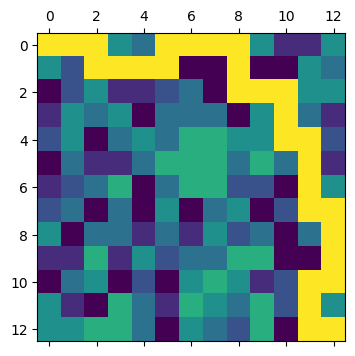

In [7]:
_ = test_path_finder.plot_path(figsize=(4, 4))

Moving on to the full puzzle input, let's repeat the above steps:

In [8]:
path_finder = PathFinder(input_17)
path_finder.compute_path()
_ = path_finder.find_best()

Best final total: 953


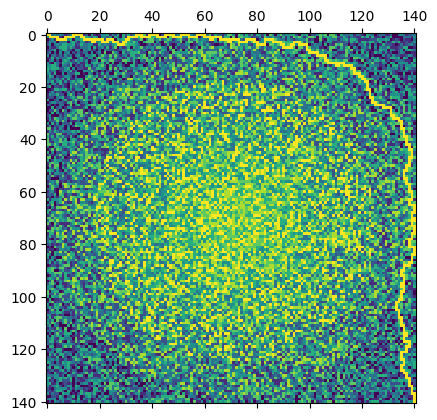

In [9]:
_ = path_finder.plot_path()

As we can see, the chosen path conveniently avoids the cluster of large values distributed around the center of the grid, trading an increased path length for a reduced overall cost. As is printed above, the solution to part 1 is: __953__.

## Part 2

The second part of the puzzle adds further restrictions onto the movement of the crucible through the grid. Specifically, after each turn, the crucible must travel a minimum of 4 steps and a maximum of 10 steps. Thankfully, in the implementation of `PathFinder`, there is the option to provide these minimum and maximum step values. They are used during the main A* algorithm loop, when computing the valid neighbours of a given graph node:

This implementation of `step_range` completely determines the valid neighbours to consider, and does not require the modification of the A* algorithm anywhere else. Trying this out on the test example once again:

In [10]:
test_path_finder_ultra = PathFinder(test_input, min_step=4, max_step=10)
test_path_finder_ultra.compute_path()
test_path_finder_ultra.find_best()

Best final total: 94


{(12, 12): (4, 12), (4, 12): (4, 8), (4, 8): (0, 8), (0, 8): (0, 0)}

(<Figure size 640x480 with 1 Axes>, <Axes: >)

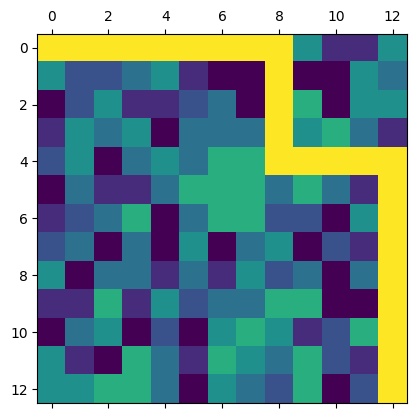

In [11]:
test_path_finder_ultra.plot_path()

As expected, the path turn less frequently than before, and incurs a higher cost as well. Applying one more time to the larger input grid:

In [12]:
path_finder_ultra = PathFinder(input_17, min_step=4, max_step=10)
path_finder_ultra.compute_path()
_ = path_finder_ultra.find_best()

Best final total: 1180


So the answer to part 2 of this puzzle is: __1180__.
    
Plotting once again the found optimial path, over the heat map of grid values:

(<Figure size 640x480 with 1 Axes>, <Axes: >)

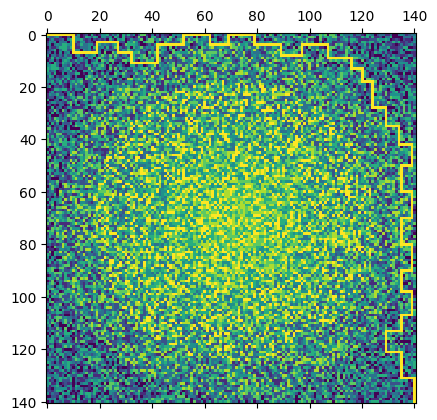

In [13]:
path_finder_ultra.plot_path()

The path follows a similar path around the central cluster, but with fewer turns and a larger incurred cost.

Extra reading:
- [A* algorithm](https://en.wikipedia.org/wiki/A*_search_algorithm)